# SENTIMENT SCORING

**File:** SentimentScoring.ipynb

**Course:** Data Science Foundations: Data Mining in Python

### Install and Import

We'll use Python library `afinn` to score sentiments. It can be installed with Python's `pip` command. This command only needs to be done once per machine. (We're also using `nltk`, a package we used in an earlier demonstration. If you don't have it installed already, you'll need to use the code below again, just swapping in `nltk` where `afinn` is.

The standard, shorter approach may work:

In [7]:
pip install afinn

     |████████████████████████████████| 52 kB 901 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=8cb013f3497ddcc3408eb70e5a2f6eb321db2006b02a6a620b22643107250958
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [8]:
# import sys
# !{sys.executable} -m pip install afinn

Once `afinn` is installed, then load the libraries below.

In [11]:
# Import libraries
import re  # For regular expressions
import nltk  # For text functions
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For dataframes
from afinn import Afinn  # For sentiment values

# Import corpora and functions from NLTK
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

# Download data for NLTK
nltk.download('stopwords', quiet=True)
nltk.download('opinion_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

# Use Matplotlib style sheet
plt.style.use('ggplot')

### Import Data

In [13]:
df = pd.read_csv('Iliad.txt',sep='\t')\
    .dropna()\
    .drop('gutenberg_id', 1)

df.head(10)

,text
0,THE ILIAD OF HOMER
2,RENDERED INTO ENGLISH BLANK VERSE.
3,BY
5,EDWARD EARL OF DERBY.
10,PREFACE.
13,"In the spring of 1862 I was induced, at the re..."
14,"friends, to print, for private circulation onl..."
15,"""Translations of Poems Ancient and Modern,"" in..."
16,first Book of the Iliad. The opinions expresse...
17,judges of the degree of success which had atte...


## DATA Prep


### Add Line Numbers

- These numbers will be used to divide the text into sections.

In [14]:
df['line'] = range(1, len(df) + 1)

df.head()

,text,line
0,THE ILIAD OF HOMER,1
2,RENDERED INTO ENGLISH BLANK VERSE.,2
3,BY,3
5,EDWARD EARL OF DERBY.,4
10,PREFACE.,5


### Tokenize the Data

In [15]:
def clean_text(text):
    text = text.lower()  # Convert all text to lowercase
    text = text.replace("'", '')
    text = re.sub(r'[^\w]', ' ', text)  # Leave only word characters
    text = re.sub(r'\s+', ' ', text)  # Omit extra space characters
    text = text.strip()
    return text

df['text'] = df['text'].map(clean_text) 
df['text'] = df['text'].map(word_tokenize) # Split text into word tokens

df.head()

,text,line
0,"[the, iliad, of, homer]",1
2,"[rendered, into, english, blank, verse]",2
3,[by],3
5,"[edward, earl, of, derby]",4
10,[preface],5


### Collect Tokens into a Single Series

In [16]:
df = df.explode('text').rename(columns={'text': 'token'})

df.head(10)

,token,line
0,the,1
0,iliad,1
0,of,1
0,homer,1
2,rendered,2
2,into,2
2,english,2
2,blank,2
2,verse,2
3,by,3


## SCORE SENTIMENTS

- Calculate sentiment scores using the AFINN lexicon, which scores words on a scale of -5 (most negative) to +5 (most positive).

In [17]:
afinn_scorer = Afinn()

df['score'] = df['token'].map(afinn_scorer.score).astype(int)
df = df[df['score'] != 0]

- Show a frequency table for the sentiment scores.

In [18]:
score_freq = df.score.value_counts().sort_index().to_frame('n')

score_freq

,n
-5,12
-4,9
-3,817
-2,2612
-1,1679
1,1269
2,2590
3,759
4,110


## Graph Score Frequencies

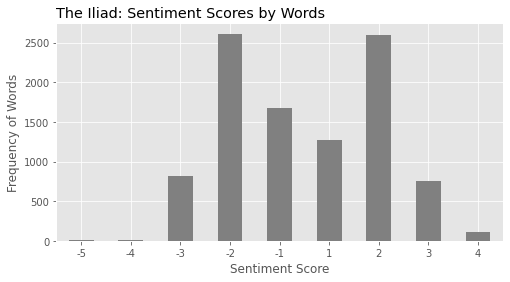

In [19]:
score_freq.plot.bar(
    legend=False,
    figsize=(8, 4),
    grid=True,
    color='gray')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency of Words')
plt.title('The Iliad: Sentiment Scores by Words', loc='left')
plt.xticks(rotation=0);

## SENTIMENT ARC

- Divide the text into sections of 100 lines and calculate a sentiment score for each section.

In [20]:
score_acc = df.groupby(df['line'] // 100)\
    .score.mean()\
    .to_frame('score')\
    .rename_axis('section')

score_acc.head(10)

,score
section,
0,0.805970
1,-0.396825
2,-0.153846
3,0.306452
4,-0.244444
5,-0.142857
6,-0.150943
7,0.060000
8,-0.175439


### Plot Scores by Section to View Narrative Arc

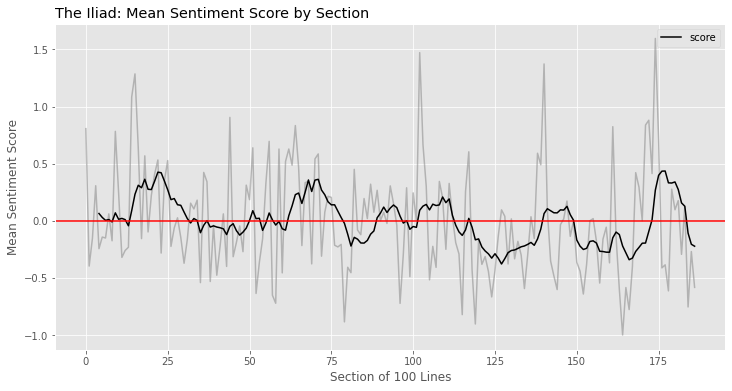

In [21]:
ax = score_acc.plot.line(legend=False, figsize=(12, 6), grid=True, alpha=0.5, color='gray')
score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='black')
plt.xlabel('Section of 100 Lines')
plt.ylabel('Mean Sentiment Score')
plt.title('The Iliad: Mean Sentiment Score by Section', loc='left')
plt.axhline(0, color='red')
plt.xticks(rotation=0);

Being a battle tale, it does hover very close to neutral often dipping into negative sentiment, with some positive beginnings but eventually ending sad.